# FEATURES

In [1]:
from datasets import get_dataset_split_names
from datasets import load_dataset
from datasets import dataset_dict
from datasets import arrow_dataset
import string

dataset = load_dataset("imdb")

/Users/nanditraore/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imdb (/Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
100%|██████████| 3/3 [00:00<00:00, 55.05it/s]


In [2]:
def preprocess(data : dict) -> dict:
    '''Takes a document from a dataset, lowers the letters and
    replace all punctuations by spaces'''
    text = data["text"]
    for character in string.punctuation:
        if character != "-" and character != "!":
          text = text.replace(character, ' ')
    data["text"] = text.lower()
    return data

In [3]:
updated_dataset= dataset.map(preprocess)

Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-a1ff6ac6f3dae5b2.arrow
Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-3ff24866f561b56d.arrow
Loading cached processed dataset at /Users/nanditraore/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c8e6bf051898815c.arrow


In [4]:
import math
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def build_single_feature(text : string):
    '''Updates the Vocabulary by adding the words contained in the text'''

    word_count = 0
    base_vector = [0,0,0,0.0,0,0]
    feature_vector = np.array(base_vector)
    Analyser = SentimentIntensityAnalyzer()

    for word in text.split():
        word_count += 1
        if (word == "no") :
            feature_vector[0] = 1
        if (word == "i" or word == "you") :
            feature_vector[1] +=  1
        if (word == "!") :
            feature_vector[2] = 1
        test_dict = Analyser.polarity_scores(word)
        if (test_dict["compound"] >= 0.05):
            feature_vector[4] += 1
        elif (test_dict["compound"] <= -0.05):
            feature_vector[5] += 1
    feature_vector[3] = math.log(word_count)

    return feature_vector

def build_all_features(dataset : dataset_dict.DatasetDict) -> dict[int]:
    '''Construct a vocabulary from the documents contained in dataset'''
    list_vector = []
    #list_label = []
    for document in dataset:
        feature_vector = build_single_feature(document["text"])
        list_vector.append(feature_vector)
       # list_label.append(document["label"])
    features_vector = np.array(list_vector)

    return features_vector

In [5]:
train_feature_vectors = build_all_features(updated_dataset["train"])
test_feature_vectors = build_all_features(updated_dataset["test"])

# II REGRESSION LINEAIRE

# 1- Adaptation of the code with our vectors of features

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

In [7]:
# Forcing the random seed for reproductibility
np.random.seed(seed=42)

train_labels = updated_dataset["train"]["label"]
test_labels = updated_dataset["test"]["label"]


In [9]:
df = pd.DataFrame()
df["no"] = train_feature_vectors[:, 0]
df["pronouns"] = train_feature_vectors[:, 1]
df["!"] = train_feature_vectors[:, 2]
df["Log(word_count)"] = train_feature_vectors[:, 3]
df["positive"] = train_feature_vectors[:, 4]
df["negative"] = train_feature_vectors[:, 5]


df["label"] = train_labels



In [24]:

all_points = torch.tensor(train_feature_vectors, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32).reshape(-1, 1)

X_test = torch.tensor(test_feature_vectors, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype= torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    all_points,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=10,
)



/var/folders/rd/ls4j_fnj1vz6qv904d5m_qh00000gn/T/ipykernel_26954/2677145971.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32).reshape(-1, 1)


In [25]:
class LogisticRegression(nn.Module):
    """A logistic regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        output_layer = nn.Sigmoid() if nb_classes == 1 else nn.Softmax()
        self.classifier = torch.nn.Sequential(
            nn.Linear(input_dim, nb_classes),
            output_layer,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of activation function.
        """
        return self.classifier(x)

In [26]:
model = LogisticRegression(6, 1)
criterion = nn.BCELoss()  # Binary cross entropy
# Stochastic gradient descent
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)



In [27]:
%%time

n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)


tensor(1.8693, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5869, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5855, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5846, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5841, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyBackward0>)
CPU times: user 1 s, sys: 16.6 ms, total: 1.02 s
Wall time: 1.14 s


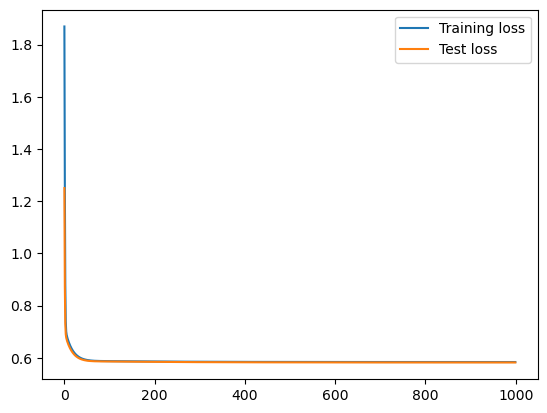

In [28]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()


# 2- Evaluate the classifier in terms of accuracy for the training

In [29]:
# Computing the accuracy for our 3 splits.
with torch.no_grad():
    p_train = model(X_train)
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = model(X_valid)
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = model(X_test)
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print(training_accuracy,valid_accuracy, test_accuracy)

0.7116 0.7178 0.714


# 3- THe weights : Which features seems to play most to both classes

En analysant les différents poids, on observe que celui qui semble influencer le plus sur nos classes est celui correspondant à la gestion du lexique positif.

In [30]:
# Looking at the model's weights and bias.
model.classifier[0].state_dict()["weight"], model.classifier[0].state_dict()["bias"]


(tensor([[-0.0289, -0.0486, -0.0047, -0.0177,  0.1239, -0.1442]]),
 tensor([-0.0021]))